In [ ]:
!pip install tensorflow==2.2.0

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
zip_path = '/content/drive/MyDrive/dataset_model_fake.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '{zip_path}' .

In [ ]:
!unzip dataset_model_fake.zip

In [ ]:
!pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pickle

In [ ]:
# Import the Data
full_data = []

IMG_SIZE = 200
DATADIR = "dataset_model_fake" # We try to import data in first folder "real_and_fake_face"
CATEGORIES = ["training_fake", "training_real"]

def create_data(DATADIR,CATEGORIES):
    for category in CATEGORIES:  # do "fake" and "real"

        path = os.path.join(DATADIR,category)  # create path to "fake", "real"
        class_num = CATEGORIES.index(category)  # get the classification 0="fake" and 1="real"

        for img in tqdm(os.listdir(path)):  # iterate over each image per "fake" and "real"
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                full_data.append([new_array, class_num])  # add this to our full_data
            except Exception as e:  # in the interest in keeping the output clean
                pass

create_data(DATADIR,CATEGORIES) # Call function

100%|██████████| 2052/2052 [00:33<00:00, 62.09it/s]


In [ ]:
print(full_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(len(full_data)) #the number of our data

4018


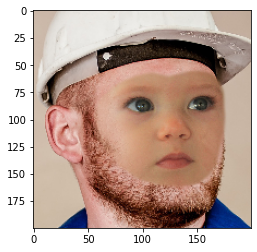

In [ ]:
# display one of our data
plt.imshow(cv2.cvtColor(full_data[1][0], cv2.COLOR_BGR2RGB))  # graph it
plt.show()  # display!

In [ ]:
# save data
pickle_out = open("full_data.pickle","wb")
pickle.dump(full_data, pickle_out)
pickle_out.close()

In [ ]:
# load data
pickle_in = open("full_data.pickle","rb")
mydata = pickle.load(pickle_in)

In [ ]:
from sklearn.model_selection import train_test_split

Y = []
for _,label in mydata:
    Y.append(label)
training, testing = train_test_split(
    mydata,               # Dataset
    train_size = 0.90,    # Proportion of training data 90% and testing data 10%
    stratify = Y,         # Stratified Sampling
    shuffle=True,
    random_state=42)

In [ ]:
print("the number of training data", len(training))
print("the number of testing data", len(testing))

the number of training data 3616
the number of testing data 402


In [ ]:
X_training = [];Y_training = [];X_testing = [];Y_testing = []

for features,label in training:
    X_training.append(features)
    Y_training.append(label)
for features,label in testing:
    X_testing.append(features)
    Y_testing.append(label)

In [ ]:
from tensorflow.keras.utils import to_categorical

#Change to float datatype
X_training = np.array(X_training).astype('float32')
X_testing = np.array(X_testing).astype('float32')

# Scale the data to lie between 0 to 1
X_training /= 255
X_testing /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(Y_training)
test_labels_one_hot = to_categorical(Y_testing)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, ZeroPadding2D, AveragePooling2D, Activation, BatchNormalization 

# Define the Model
# -----------------

def CreateModel():
    model = Sequential()
    
    # The first layer with 16 filters of window size 3x3
    model.add(Conv2D(16, (3, 3), padding='same', input_shape =(200,200,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation("softmax"))
    
    return model

In [ ]:
# Configure the Model
# -------------------
from tensorflow.keras.optimizers import Adam
model = CreateModel()
model.compile(optimizer=Adam(lr=1e-4, decay=1e-4/20), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
activation (Activation)      (None, 200, 200, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)     

In [ ]:
history = model.fit(X_training, train_labels_one_hot, batch_size=8, epochs=50, verbose=1,
                   validation_data=(X_testing, test_labels_one_hot))

Epoch 1/50
452/452 [==============================] - 8s 18ms/step - loss: 1.0262 - accuracy: 0.5080 - val_loss: 2.8681 - val_accuracy: 0.4975
Epoch 2/50
452/452 [==============================] - 7s 17ms/step - loss: 0.8950 - accuracy: 0.5340 - val_loss: 2.4233 - val_accuracy: 0.4950
Epoch 3/50
452/452 [==============================] - 8s 17ms/step - loss: 0.8375 - accuracy: 0.5567 - val_loss: 2.6821 - val_accuracy: 0.5597
Epoch 4/50
452/452 [==============================] - 8s 17ms/step - loss: 0.7956 - accuracy: 0.5713 - val_loss: 2.8070 - val_accuracy: 0.5323
Epoch 5/50
452/452 [==============================] - 8s 17ms/step - loss: 0.7286 - accuracy: 0.6114 - val_loss: 1.3444 - val_accuracy: 0.5398
Epoch 6/50
452/452 [==============================] - 8s 17ms/step - loss: 0.6740 - accuracy: 0.6449 - val_loss: 1.3948 - val_accuracy: 0.5075
Epoch 7/50
452/452 [==============================] - 8s 17ms/step - loss: 0.6308 - accuracy: 0.6762 - val_loss: 1.2809 - val_accuracy: 0.5149

Text(0.5, 1.0, 'Accuracy Curves')

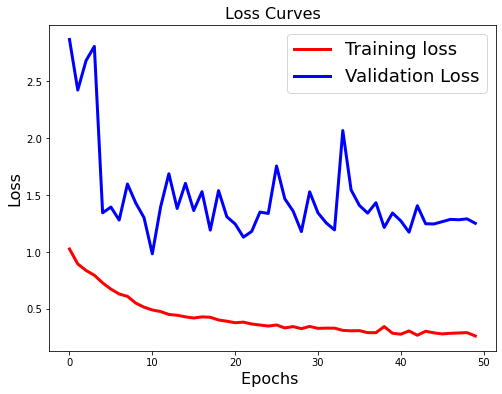

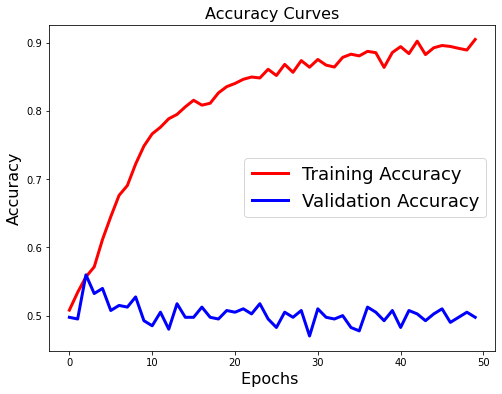

In [ ]:
# Checkout the Loss and Accuracy Curves
# -------------------------------------
# Plot the Loss Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

# Plot the Accuracy Curves
plt.figure(figsize=[8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)


In [ ]:
# Evaluate the Model
# ------------------
model.evaluate(X_testing, test_labels_one_hot) # loss and accuracy of testing data

13/13 [==============================] - 0s 28ms/step - loss: 1.2522 - accuracy: 0.4975


[1.2522273063659668, 0.49751242995262146]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


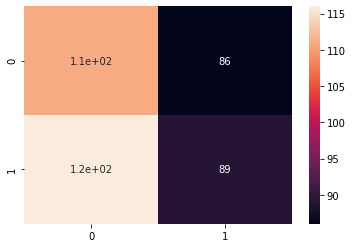

In [ ]:
#Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_predict_class = model.predict_classes(X_testing)
sns.heatmap(confusion_matrix(Y_testing, test_predict_class, labels=[0,1]),annot=True) # 0="Fake" and 1="Real"

In [ ]:
# Save Model to Json
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')

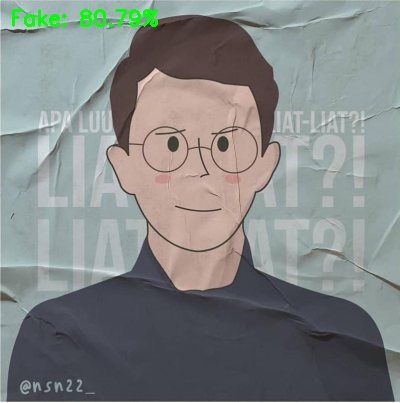

Fake: 80.79%


In [ ]:
from tensorflow.keras.models import load_model, model_from_json
from google.colab.patches import cv2_imshow
import json
import imutils

# Load model from Json file 
json_file = open('model.json','r')
loaded_model = json_file.read()
json_file.close()

load_model = model_from_json(loaded_model)
load_model.load_weights('model.h5')

# Load One Image for classification
image = cv2.imread('/content/IMG-20210605-WA0030.jpg') # We take one image example for trying the model 

# pre-process the image for classification
IMG_SIZE = 200
im = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
im = im.astype("float") / 255.0
im = np.array(im).astype('float32')
im = np.expand_dims(im, axis=0)

# Make Prediction 
(Fake,Real) = load_model.predict(im)[0]

# build the label
label = "Fake" if Fake > Real else "Real"
proba = Fake if Fake > Real else Real
label = "{}: {:.2f}%".format(label, proba * 100)

# draw the label on the image
output = imutils.resize(image, width=400)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# show the output image
cv2_imshow(output)
cv2.waitKey(0)

print(label)

In [ ]:
!pip list

Package                       Version            
----------------------------- -------------------
-ensorflow                    2.4.0              
absl-py                       0.12.0             
alabaster                     0.7.12             
albumentations                0.1.12             
altair                        4.1.0              
appdirs                       1.4.4              
argon2-cffi                   20.1.0             
arviz                         0.11.2             
astor                         0.8.1              
astropy                       4.2.1              
astunparse                    1.6.3              
async-generator               1.10               
atari-py                      0.2.9              
atomicwrites                  1.4.0              
attrs                         21.2.0             
audioread                     2.1.9              
autograd                      1.3                
Babel                         2.9.1              


In [ ]:
from keras.models import load_model, model_from_json
from google.colab.patches import cv2_imshow
import json
import imutils

# Load model from Json file 
json_file = open('model.json','r')
loaded_model = json_file.read()
json_file.close()

load_model = model_from_json(loaded_model)
load_model.load_weights('model.h5')

# Load One Image for classification
image = cv2.imread('dataset_model_fake/training_real/Clipboard (15).jpg') # We take one image example for trying the model 

# pre-process the image for classification
im = cv2.resize(image, (IMG_SIZE,IMG_SIZE))
im = im.astype("float") / 255.0
im = np.array(im).astype('float32')
im = np.expand_dims(im, axis=0)

# Make Prediction 
(Fake,Real) = load_model.predict(im)[0]

# build the label
label = "Fake" if Fake > Real else "Real"
proba = Fake if Fake > Real else Real
label = "{}: {:.2f}%".format(label, proba * 100)

# draw the label on the image
output = imutils.resize(image, width=400)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# show the output image
cv2_imshow(output)
cv2.waitKey(0)

print(label)

ImportError: ignored